## Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel, RandomForestReg, RnnDlModel_test 
from bitcoin_deep_learning.trainer import read_result, cv_train
from bitcoin_deep_learning.cross_val import get_cross_XY
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

## Getting data

In [3]:
train_df = ApiCall().get_raw_glassnode_data()
#read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.57s/it]


In [11]:
ApiCall().data_to_csv(train_df, name = 'all_data.csv')

date  [AVG]_[NH]_mean_hash_rate  [+]_[NH]_Days_Till_Halving  \
0    2011-09-16               1.036434e+13                         439   
1    2011-09-17               1.161376e+13                         438   
2    2011-09-18               1.363396e+13                         437   
3    2011-09-19               1.113934e+13                         436   
4    2011-09-20               1.214578e+13                         435   
...         ...                        ...                         ...   
3823 2022-03-05               1.686245e+20                         785   
3824 2022-03-06               1.789926e+20                         784   
3825 2022-03-07               2.033926e+20                         783   
3826 2022-03-08               2.023772e+20                         782   
3827 2022-03-09               1.888209e+20                         781   

      [//]_[AV]_Stock-to-Flow_Ratio  [+]_[NH]_Circulating_Supply  \
0                          1.418819                   7282650.00   
1                          1.429329                   7289350.00   
2                          1.441211                   7297250.00   
3                          1.452215                   7303600.00   
4                          1.462380                   7310600.00   
...                             ...                          ...   
3823                  108708.531831                  18975393.75   
3824                  108870.777114                  18976212.50   
3825                  108875.720822                  18977137.50   
3826                  108943.145857                  18978062.50   
3827                  108974.601445                  18978925.00   

      [+]_[NH]_Issuance  [+]_[NH]_Number_of_Active_Addresses  \
0               5950.00                                14298   
1               6700.00                                12877   
2               7900.00                                14074   
3               6350.00                                15826   
4               7000.00                                21668   
...                 ...                                  ...   
3823             768.75                               810397   
3824             818.75                               776309   
3825             925.00                               918501   
3826             925.00                               956336   
3827             862.50                               962981   

      [+]_[NH]_Mean_Block_Interval  [+]_[NH]_Number_of_Transactions  \
0                              508                             6090   
1                              455                             5320   
2                              349                             5828   
3                              454                             6526   
4                              422                             8005   
...                            ...                              ...   
3823                           439                           225198   
3824                           543                           206985   
3825                           458                           255293   
3826                           358                           255623   
3827                           396                           272667   

      [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance  ...  \
0                                                494042     ...   
1                                                494415     ...   
2                                                494962     ...   
3                                                495218     ...   
4                                                499994     ...   
...                                                 ...     ...   
3823                                           40364804     ...   
3824                                           40386891     ...   
3825                                           40390661     ...   
3826         

In [4]:
train_df.columns

Index(['date', '[AVG]_[NH]_mean_hash_rate', '[+]_[NH]_Days_Till_Halving',
       '[//]_[AV]_Stock-to-Flow_Ratio', '[+]_[NH]_Circulating_Supply',
       '[+]_[NH]_Issuance', '[+]_[NH]_Number_of_Active_Addresses',
       '[+]_[NH]_Mean_Block_Interval', '[+]_[NH]_Number_of_Transactions',
       '[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.01',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.1',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_1',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_100',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_1k',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k',
       '[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago',
       '[//]_[BSB]_Realized_HODL_Ratio',
       '[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)',
       '[//]_[BSB]_Liveliness',
       '[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_

In [12]:
(train_df.shape[0] - (30*(12+3)+6)) // 30

112

In [13]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY(train_df.iloc[7:-90].drop(columns="date"), data=None, verbose = 2)

The set is being split in 109 folds


In [14]:
np.array(X_train_list).shape

(110,)

In [15]:
np.array(Y_test_list).shape

(110, 90)

## Ploting models

### Plotting prediction per folds

In [16]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 4, figsize = (25,350))
    scores = []
    for k in range(len(X_train_list)): #range(5):#
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        y_pred = model.run(X_test, X_train, y_train)
        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].set_ylabel('Price growth rate 7 days')
        axs[k, 0].set_xlabel('Fold sequence length in days')
        axs[k, 0].legend(loc='upper right')
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].set_ylabel('Price growth rate 7 days')
        axs[k, 1].set_xlabel('Fold sequence length in days')
        axs[k, 1].legend(loc='upper right');
        axs[k, 2].plot(model.history.history['mae'], color = 'y', label = 'mae')
        axs[k, 2].plot(model.history.history['val_mae'], color = 'b', label = 'val_mae')
        axs[k, 2].set_title('model mae')
        axs[k, 2].set_ylabel('mae')
        axs[k, 2].set_xlabel('epoch')
        axs[k, 2].legend(['train', 'test'], loc='upper right')
        axs[k, 3].plot(model.history.history['loss'], color = 'y', label = 'mae')
        axs[k, 3].plot(model.history.history['val_loss'], color = 'b', label = 'val_mae')
        axs[k, 3].set_title('model train vs validation loss')
        axs[k, 3].set_ylabel('loss')
        axs[k, 3].set_xlabel('epoch')
        axs[k, 3].legend(['train', 'validation'], loc='upper right')
        if k == 1:
            print(model.model.summary())
        print(f'############### next fold => number {k} ########## ')
    print("Mean absolute error - mean") 
    print(np.array(scores).mean())
    print("Mean absolute error - std") 
    print(np.array(scores).std())
    

### RNN Tuning

#### Tuning RNN

2022-03-10 16:04:21.927474: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 16:04:22.058303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
4/4 [==============================] - 3s 216ms/step - loss: 0.0610 - mae: 0.0763 - val_loss: 0.0720 - val_mae: 0.1009
Epoch 2/20
4/4 [==============================] - 0s 78ms/step - loss: 0.0487 - mae: 0.0730 - val_loss: 0.0743 - val_mae: 0.1040
Epoch 3/20
4/4 [==============================] - 0s 71ms/step - loss: 0.0505 - mae: 0.0718 - val_loss: 0.0723 - val_mae: 0.1006
Epoch 4/20
4/4 [==============================] - 0s 75ms/step - loss: 0.0457 - mae: 0.0706 - val_loss: 0.0725 - val_mae: 0.1015
Epoch 5/20
4/4 [==============================] - 0s 76ms/step - loss: 0.0481 - mae: 0.0704 - val_loss: 0.0773 - val_mae: 0.0953
Epoch 6/20
4/4 [==============================] - 0s 73ms/step - loss: 0.0471 - mae: 0.0698 - val_loss: 0.0728 - val_mae: 0.1018
Epoch 7/20
4/4 [==============================] - 0s 70ms/step - loss: 0.0487 - mae: 0.0711 - val_loss: 0.0747 - val_mae: 0.1057
Epoch 8/20
4/4 [==============================] - 0s 72ms/step - loss: 0.0487 - mae: 0.0713 - va

4/4 [==============================] - 0s 81ms/step - loss: 0.0260 - mae: 0.0558 - val_loss: 0.0148 - val_mae: 0.0427
Epoch 11/20
4/4 [==============================] - 0s 79ms/step - loss: 0.0259 - mae: 0.0533 - val_loss: 0.0181 - val_mae: 0.0483
Epoch 12/20
4/4 [==============================] - 0s 82ms/step - loss: 0.0255 - mae: 0.0552 - val_loss: 0.0126 - val_mae: 0.0393
Epoch 13/20
4/4 [==============================] - 0s 79ms/step - loss: 0.0249 - mae: 0.0529 - val_loss: 0.0135 - val_mae: 0.0446
Epoch 14/20
4/4 [==============================] - 0s 78ms/step - loss: 0.0330 - mae: 0.0569 - val_loss: 0.0148 - val_mae: 0.0433
Epoch 15/20
4/4 [==============================] - 0s 77ms/step - loss: 0.0270 - mae: 0.0553 - val_loss: 0.0124 - val_mae: 0.0388
Epoch 16/20
4/4 [==============================] - 0s 84ms/step - loss: 0.0222 - mae: 0.0517 - val_loss: 0.0129 - val_mae: 0.0399
Epoch 17/20
4/4 [==============================] - 0s 80ms/step - loss: 0.0258 - mae: 0.0533 - val_los

Epoch 1/20
4/4 [==============================] - 4s 231ms/step - loss: 0.0369 - mae: 0.0591 - val_loss: 0.0111 - val_mae: 0.0933
Epoch 2/20
4/4 [==============================] - 0s 80ms/step - loss: 0.0299 - mae: 0.0539 - val_loss: 0.0113 - val_mae: 0.0942
Epoch 3/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0279 - mae: 0.0541 - val_loss: 0.0891 - val_mae: 0.1271
Epoch 4/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0296 - mae: 0.0543 - val_loss: 0.0153 - val_mae: 0.1136
Epoch 5/20
4/4 [==============================] - 0s 81ms/step - loss: 0.0295 - mae: 0.0534 - val_loss: 0.0137 - val_mae: 0.1061
Epoch 6/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0312 - mae: 0.0539 - val_loss: 0.2138 - val_mae: 0.1379
Epoch 7/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0268 - mae: 0.0539 - val_loss: 0.2440 - val_mae: 0.1469
Epoch 8/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0311 - mae: 0.0541 - va

4/4 [==============================] - 0s 100ms/step - loss: 0.4007 - mae: 0.1445 - val_loss: 0.0874 - val_mae: 0.0915
Epoch 6/20
4/4 [==============================] - 0s 85ms/step - loss: 0.2050 - mae: 0.1226 - val_loss: 0.0524 - val_mae: 0.0879
Epoch 7/20
4/4 [==============================] - 0s 87ms/step - loss: 0.2226 - mae: 0.1214 - val_loss: 0.0913 - val_mae: 0.1240
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 0.2642 - mae: 0.1412 - val_loss: 0.0822 - val_mae: 0.1170
Epoch 9/20
4/4 [==============================] - 0s 85ms/step - loss: 0.2683 - mae: 0.1328 - val_loss: 0.1936 - val_mae: 0.1195
Epoch 10/20
4/4 [==============================] - 0s 92ms/step - loss: 0.1972 - mae: 0.1224 - val_loss: 0.2127 - val_mae: 0.1395
Epoch 11/20
4/4 [==============================] - 0s 91ms/step - loss: 0.1738 - mae: 0.1134 - val_loss: 0.1223 - val_mae: 0.1146
Epoch 12/20
4/4 [==============================] - 0s 86ms/step - loss: 0.2035 - mae: 0.1221 - val_loss: 

Epoch 3/20
4/4 [==============================] - 0s 88ms/step - loss: 0.3401 - mae: 0.1562 - val_loss: 0.0357 - val_mae: 0.0716
Epoch 4/20
4/4 [==============================] - 0s 96ms/step - loss: 0.3478 - mae: 0.1543 - val_loss: 0.1013 - val_mae: 0.0879
Epoch 5/20
4/4 [==============================] - 0s 86ms/step - loss: 0.3295 - mae: 0.1527 - val_loss: 0.0384 - val_mae: 0.0744
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 0.2479 - mae: 0.1509 - val_loss: 0.0327 - val_mae: 0.0683
Epoch 7/20
4/4 [==============================] - 0s 88ms/step - loss: 0.3019 - mae: 0.1433 - val_loss: 0.0469 - val_mae: 0.0794
Epoch 8/20
4/4 [==============================] - 0s 93ms/step - loss: 0.2772 - mae: 0.1503 - val_loss: 0.0377 - val_mae: 0.0740
Epoch 9/20
4/4 [==============================] - 0s 96ms/step - loss: 0.2611 - mae: 0.1503 - val_loss: 0.0346 - val_mae: 0.0705
Epoch 10/20
4/4 [==============================] - 0s 86ms/step - loss: 0.2666 - mae: 0.1445 - va

Epoch 10/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0626 - mae: 0.0935 - val_loss: 0.2905 - val_mae: 0.1707
Epoch 11/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0556 - mae: 0.0910 - val_loss: 0.2439 - val_mae: 0.1541
Epoch 12/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0585 - mae: 0.0900 - val_loss: 0.2139 - val_mae: 0.1299
Epoch 13/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0609 - mae: 0.0908 - val_loss: 0.2021 - val_mae: 0.1400
Epoch 14/20
4/4 [==============================] - 0s 98ms/step - loss: 0.0518 - mae: 0.0901 - val_loss: 0.1429 - val_mae: 0.1384
Epoch 15/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0455 - mae: 0.0873 - val_loss: 0.2445 - val_mae: 0.1553
Epoch 16/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0496 - mae: 0.0858 - val_loss: 0.2425 - val_mae: 0.1582
Epoch 17/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0484 - mae: 0.08

############### next fold => number 20 ########## 
Epoch 1/20
4/4 [==============================] - 5s 340ms/step - loss: 0.1418 - mae: 0.1275 - val_loss: 0.0956 - val_mae: 0.0963
Epoch 2/20
4/4 [==============================] - 1s 114ms/step - loss: 0.0937 - mae: 0.1153 - val_loss: 0.1149 - val_mae: 0.1061
Epoch 3/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0820 - mae: 0.1159 - val_loss: 0.1285 - val_mae: 0.1130
Epoch 4/20
4/4 [==============================] - 0s 95ms/step - loss: 0.0761 - mae: 0.1067 - val_loss: 0.1237 - val_mae: 0.1111
Epoch 5/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0869 - mae: 0.1058 - val_loss: 0.1049 - val_mae: 0.1001
Epoch 6/20
4/4 [==============================] - 0s 98ms/step - loss: 0.0836 - mae: 0.1088 - val_loss: 0.1365 - val_mae: 0.1174
Epoch 7/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0680 - mae: 0.1018 - val_loss: 0.1238 - val_mae: 0.1099
Epoch 8/20
4/4 [============================

4/4 [==============================] - 0s 88ms/step - loss: 0.0691 - mae: 0.0929 - val_loss: 0.0578 - val_mae: 0.0657
Epoch 12/20
4/4 [==============================] - 0s 95ms/step - loss: 0.0610 - mae: 0.0902 - val_loss: 0.1000 - val_mae: 0.0985
Epoch 13/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0740 - mae: 0.0969 - val_loss: 0.0723 - val_mae: 0.0783
Epoch 14/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0685 - mae: 0.0911 - val_loss: 0.0581 - val_mae: 0.0647
Epoch 15/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0605 - mae: 0.0905 - val_loss: 0.0524 - val_mae: 0.0585
############### next fold => number 24 ########## 
Epoch 1/20
4/4 [==============================] - 4s 254ms/step - loss: 0.0476 - mae: 0.0763 - val_loss: 0.0756 - val_mae: 0.0716
Epoch 2/20
4/4 [==============================] - 0s 97ms/step - loss: 0.0384 - mae: 0.0700 - val_loss: 0.0179 - val_mae: 0.0575
Epoch 3/20
4/4 [==============================] - 0s

4/4 [==============================] - 0s 104ms/step - loss: 0.0348 - mae: 0.0641 - val_loss: 0.2412 - val_mae: 0.1283
Epoch 3/20
4/4 [==============================] - 0s 129ms/step - loss: 0.0341 - mae: 0.0632 - val_loss: 0.2460 - val_mae: 0.1293
Epoch 4/20
4/4 [==============================] - 1s 152ms/step - loss: 0.0376 - mae: 0.0646 - val_loss: 0.1955 - val_mae: 0.1221
Epoch 5/20
4/4 [==============================] - 1s 159ms/step - loss: 0.0273 - mae: 0.0614 - val_loss: 0.1994 - val_mae: 0.1210
Epoch 6/20
4/4 [==============================] - 0s 108ms/step - loss: 0.0280 - mae: 0.0623 - val_loss: 0.2366 - val_mae: 0.1253
Epoch 7/20
4/4 [==============================] - 0s 100ms/step - loss: 0.0241 - mae: 0.0613 - val_loss: 0.1580 - val_mae: 0.1200
Epoch 8/20
4/4 [==============================] - 0s 98ms/step - loss: 0.0252 - mae: 0.0612 - val_loss: 0.2673 - val_mae: 0.1367
Epoch 9/20
4/4 [==============================] - 0s 99ms/step - loss: 0.0264 - mae: 0.0612 - val_loss

4/4 [==============================] - 0s 89ms/step - loss: 0.0455 - mae: 0.0758 - val_loss: 0.0199 - val_mae: 0.0469
Epoch 7/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0460 - mae: 0.0767 - val_loss: 0.0153 - val_mae: 0.0409
Epoch 8/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0451 - mae: 0.0750 - val_loss: 0.0126 - val_mae: 0.0369
Epoch 9/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0381 - mae: 0.0720 - val_loss: 0.0184 - val_mae: 0.0451
Epoch 10/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0389 - mae: 0.0723 - val_loss: 0.0143 - val_mae: 0.0376
Epoch 11/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0387 - mae: 0.0720 - val_loss: 0.0379 - val_mae: 0.0679
Epoch 12/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0423 - mae: 0.0750 - val_loss: 0.0122 - val_mae: 0.0371
Epoch 13/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0332 - mae: 0.0701 - val_loss: 

4/4 [==============================] - 0s 94ms/step - loss: 0.0358 - mae: 0.0600 - val_loss: 0.0303 - val_mae: 0.0633
Epoch 17/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0313 - mae: 0.0574 - val_loss: 0.0320 - val_mae: 0.0614
Epoch 18/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0305 - mae: 0.0578 - val_loss: 0.0293 - val_mae: 0.0616
Epoch 19/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0288 - mae: 0.0564 - val_loss: 0.0638 - val_mae: 0.0755
Epoch 20/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0310 - mae: 0.0599 - val_loss: 0.0301 - val_mae: 0.0605
############### next fold => number 36 ########## 
Epoch 1/20
4/4 [==============================] - 5s 249ms/step - loss: 0.0599 - mae: 0.0695 - val_loss: 0.0304 - val_mae: 0.0488
Epoch 2/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0454 - mae: 0.0647 - val_loss: 0.0317 - val_mae: 0.0494
Epoch 3/20
4/4 [==============================] - 0s

Epoch 10/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0122 - mae: 0.0421 - val_loss: 0.0509 - val_mae: 0.0947
Epoch 11/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0131 - mae: 0.0427 - val_loss: 0.0961 - val_mae: 0.1036
Epoch 12/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0099 - mae: 0.0396 - val_loss: 0.1177 - val_mae: 0.1118
Epoch 13/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0139 - mae: 0.0426 - val_loss: 0.1349 - val_mae: 0.1183
Epoch 14/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0118 - mae: 0.0410 - val_loss: 0.0942 - val_mae: 0.1050
Epoch 15/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0126 - mae: 0.0415 - val_loss: 0.0895 - val_mae: 0.1034
Epoch 16/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0124 - mae: 0.0418 - val_loss: 0.0653 - val_mae: 0.0997
Epoch 17/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0112 - mae: 0.03

4/4 [==============================] - 0s 96ms/step - loss: 0.0281 - mae: 0.0601 - val_loss: 0.0103 - val_mae: 0.0365
Epoch 4/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0227 - mae: 0.0569 - val_loss: 0.0065 - val_mae: 0.0284
Epoch 5/20
4/4 [==============================] - 0s 97ms/step - loss: 0.0235 - mae: 0.0561 - val_loss: 0.0076 - val_mae: 0.0317
Epoch 6/20
4/4 [==============================] - 0s 95ms/step - loss: 0.0266 - mae: 0.0585 - val_loss: 0.0036 - val_mae: 0.0188
Epoch 7/20
4/4 [==============================] - 0s 95ms/step - loss: 0.0199 - mae: 0.0527 - val_loss: 0.0072 - val_mae: 0.0323
Epoch 8/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0236 - mae: 0.0552 - val_loss: 0.0282 - val_mae: 0.0615
Epoch 9/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0255 - mae: 0.0560 - val_loss: 0.0045 - val_mae: 0.0223
Epoch 10/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0179 - mae: 0.0525 - val_loss: 0.0

4/4 [==============================] - 0s 121ms/step - loss: 0.0182 - mae: 0.0453 - val_loss: 0.0507 - val_mae: 0.0894
Epoch 18/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0190 - mae: 0.0451 - val_loss: 0.0525 - val_mae: 0.0886
Epoch 19/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0178 - mae: 0.0450 - val_loss: 0.1006 - val_mae: 0.0936
############### next fold => number 47 ########## 
Epoch 1/20
4/4 [==============================] - 5s 366ms/step - loss: 0.0255 - mae: 0.0562 - val_loss: 0.0333 - val_mae: 0.0530
Epoch 2/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0212 - mae: 0.0539 - val_loss: 0.0594 - val_mae: 0.0774
Epoch 3/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0293 - mae: 0.0579 - val_loss: 0.0271 - val_mae: 0.0478
Epoch 4/20
4/4 [==============================] - 0s 109ms/step - loss: 0.0220 - mae: 0.0527 - val_loss: 0.0480 - val_mae: 0.0668
Epoch 5/20
4/4 [==============================] - 0s

4/4 [==============================] - 0s 93ms/step - loss: 0.0193 - mae: 0.0436 - val_loss: 0.0033 - val_mae: 0.0249
Epoch 8/20
4/4 [==============================] - 0s 118ms/step - loss: 0.0161 - mae: 0.0411 - val_loss: 0.0090 - val_mae: 0.0309
Epoch 9/20
4/4 [==============================] - 0s 104ms/step - loss: 0.0159 - mae: 0.0424 - val_loss: 0.0158 - val_mae: 0.0356
Epoch 10/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0178 - mae: 0.0433 - val_loss: 0.0108 - val_mae: 0.0327
Epoch 11/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0152 - mae: 0.0418 - val_loss: 0.0402 - val_mae: 0.0624
Epoch 12/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0189 - mae: 0.0448 - val_loss: 0.0095 - val_mae: 0.0299
Epoch 13/20
4/4 [==============================] - 0s 103ms/step - loss: 0.0152 - mae: 0.0404 - val_loss: 0.0028 - val_mae: 0.0246
Epoch 14/20
4/4 [==============================] - 0s 101ms/step - loss: 0.0156 - mae: 0.0419 - val_l

Epoch 19/20
4/4 [==============================] - 0s 122ms/step - loss: 0.0091 - mae: 0.0359 - val_loss: 0.0626 - val_mae: 0.0857
Epoch 20/20
4/4 [==============================] - 0s 98ms/step - loss: 0.0087 - mae: 0.0360 - val_loss: 0.0605 - val_mae: 0.0848
############### next fold => number 54 ########## 
Epoch 1/20
4/4 [==============================] - 6s 295ms/step - loss: 0.0211 - mae: 0.0458 - val_loss: 0.0170 - val_mae: 0.0520
Epoch 2/20
4/4 [==============================] - 0s 103ms/step - loss: 0.0165 - mae: 0.0395 - val_loss: 0.0148 - val_mae: 0.0526
Epoch 3/20
4/4 [==============================] - 0s 113ms/step - loss: 0.0131 - mae: 0.0387 - val_loss: 0.0163 - val_mae: 0.0565
Epoch 4/20
4/4 [==============================] - 0s 108ms/step - loss: 0.0122 - mae: 0.0392 - val_loss: 0.0142 - val_mae: 0.0517
Epoch 5/20
4/4 [==============================] - 0s 119ms/step - loss: 0.0107 - mae: 0.0388 - val_loss: 0.0142 - val_mae: 0.0512
Epoch 6/20
4/4 [======================

############### next fold => number 57 ########## 
Epoch 1/20
4/4 [==============================] - 5s 677ms/step - loss: 0.0971 - mae: 0.0937 - val_loss: 0.0923 - val_mae: 0.1123
Epoch 2/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0368 - mae: 0.0596 - val_loss: 0.0470 - val_mae: 0.1099
Epoch 3/20
4/4 [==============================] - 0s 100ms/step - loss: 0.0314 - mae: 0.0571 - val_loss: 0.0299 - val_mae: 0.1071
Epoch 4/20
4/4 [==============================] - 0s 112ms/step - loss: 0.0277 - mae: 0.0563 - val_loss: 0.0306 - val_mae: 0.1086
Epoch 5/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0234 - mae: 0.0559 - val_loss: 0.0293 - val_mae: 0.1058
Epoch 6/20
4/4 [==============================] - 0s 109ms/step - loss: 0.0223 - mae: 0.0547 - val_loss: 0.0299 - val_mae: 0.1071
Epoch 7/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0215 - mae: 0.0534 - val_loss: 0.0294 - val_mae: 0.1059
Epoch 8/20
4/4 [==========================

4/4 [==============================] - 0s 95ms/step - loss: 0.0386 - mae: 0.0763 - val_loss: 0.0736 - val_mae: 0.0991
Epoch 10/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0366 - mae: 0.0761 - val_loss: 0.0698 - val_mae: 0.0957
Epoch 11/20
4/4 [==============================] - 0s 83ms/step - loss: 0.0376 - mae: 0.0751 - val_loss: 0.0960 - val_mae: 0.1049
Epoch 12/20
4/4 [==============================] - 0s 97ms/step - loss: 0.0392 - mae: 0.0743 - val_loss: 0.1168 - val_mae: 0.1063
Epoch 13/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0404 - mae: 0.0801 - val_loss: 0.0936 - val_mae: 0.1052
Epoch 14/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0393 - mae: 0.0761 - val_loss: 0.0790 - val_mae: 0.0983
Epoch 15/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0370 - mae: 0.0726 - val_loss: 0.0805 - val_mae: 0.0990
############### next fold => number 61 ########## 
Epoch 1/20
4/4 [==============================] - 6

4/4 [==============================] - 0s 97ms/step - loss: 0.0469 - mae: 0.0872 - val_loss: 0.1255 - val_mae: 0.1464
Epoch 5/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0443 - mae: 0.0851 - val_loss: 0.1274 - val_mae: 0.1478
Epoch 6/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0462 - mae: 0.0864 - val_loss: 0.1188 - val_mae: 0.1400
Epoch 7/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0446 - mae: 0.0849 - val_loss: 0.1212 - val_mae: 0.1431
Epoch 8/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0429 - mae: 0.0828 - val_loss: 0.1263 - val_mae: 0.1467
Epoch 9/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0430 - mae: 0.0830 - val_loss: 0.1301 - val_mae: 0.1493
Epoch 10/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0428 - mae: 0.0837 - val_loss: 0.1219 - val_mae: 0.1430
Epoch 11/20
4/4 [==============================] - 0s 83ms/step - loss: 0.0412 - mae: 0.0805 - val_loss: 0.

Epoch 2/20
4/4 [==============================] - 0s 129ms/step - loss: 0.0949 - mae: 0.1175 - val_loss: 0.0990 - val_mae: 0.1036
Epoch 3/20
4/4 [==============================] - 0s 100ms/step - loss: 0.0717 - mae: 0.1116 - val_loss: 0.0916 - val_mae: 0.0995
Epoch 4/20
4/4 [==============================] - 0s 110ms/step - loss: 0.0800 - mae: 0.1126 - val_loss: 0.1001 - val_mae: 0.1041
Epoch 5/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0724 - mae: 0.1104 - val_loss: 0.1325 - val_mae: 0.1233
Epoch 6/20
4/4 [==============================] - 0s 98ms/step - loss: 0.0783 - mae: 0.1138 - val_loss: 0.1014 - val_mae: 0.1052
Epoch 7/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0747 - mae: 0.1092 - val_loss: 0.1199 - val_mae: 0.1159
Epoch 8/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0655 - mae: 0.1076 - val_loss: 0.1190 - val_mae: 0.1155
Epoch 9/20
4/4 [==============================] - 0s 102ms/step - loss: 0.0681 - mae: 0.1066 -

4/4 [==============================] - 0s 84ms/step - loss: 0.0694 - mae: 0.1049 - val_loss: 0.0621 - val_mae: 0.0895
Epoch 14/20
4/4 [==============================] - 0s 84ms/step - loss: 0.0623 - mae: 0.1009 - val_loss: 0.0559 - val_mae: 0.0866
Epoch 15/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0541 - mae: 0.0964 - val_loss: 0.0600 - val_mae: 0.0886
Epoch 16/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0775 - mae: 0.1068 - val_loss: 0.0860 - val_mae: 0.0995
Epoch 17/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0550 - mae: 0.0983 - val_loss: 0.0732 - val_mae: 0.0943
Epoch 18/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0575 - mae: 0.0968 - val_loss: 0.0676 - val_mae: 0.0913
Epoch 19/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0544 - mae: 0.0984 - val_loss: 0.0460 - val_mae: 0.0862
Epoch 20/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0749 - mae: 0.1029 - val_los

############### next fold => number 76 ########## 
Epoch 1/20
4/4 [==============================] - 5s 249ms/step - loss: 0.0345 - mae: 0.0645 - val_loss: 0.1906 - val_mae: 0.1305
Epoch 2/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0344 - mae: 0.0617 - val_loss: 0.1807 - val_mae: 0.1308
Epoch 3/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0297 - mae: 0.0603 - val_loss: 0.1468 - val_mae: 0.1281
Epoch 4/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0324 - mae: 0.0633 - val_loss: 0.1163 - val_mae: 0.1279
Epoch 5/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0330 - mae: 0.0608 - val_loss: 0.1166 - val_mae: 0.1273
Epoch 6/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0343 - mae: 0.0620 - val_loss: 0.0782 - val_mae: 0.1229
Epoch 7/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0302 - mae: 0.0604 - val_loss: 0.0895 - val_mae: 0.1246
Epoch 8/20
4/4 [=============================

4/4 [==============================] - 0s 88ms/step - loss: 0.0472 - mae: 0.0595 - val_loss: 0.0544 - val_mae: 0.0579
Epoch 5/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0468 - mae: 0.0597 - val_loss: 0.0550 - val_mae: 0.0585
Epoch 6/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0458 - mae: 0.0598 - val_loss: 0.0560 - val_mae: 0.0592
Epoch 7/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0457 - mae: 0.0600 - val_loss: 0.0567 - val_mae: 0.0598
Epoch 8/20
4/4 [==============================] - 0s 84ms/step - loss: 0.0463 - mae: 0.0601 - val_loss: 0.0577 - val_mae: 0.0606
Epoch 9/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0456 - mae: 0.0604 - val_loss: 0.0586 - val_mae: 0.0613
Epoch 10/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0478 - mae: 0.0605 - val_loss: 0.0598 - val_mae: 0.0623
Epoch 11/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0469 - mae: 0.0608 - val_loss: 0.

############### next fold => number 85 ########## 
Epoch 1/20
4/4 [==============================] - 4s 254ms/step - loss: 0.0470 - mae: 0.0709 - val_loss: 0.1299 - val_mae: 0.1013
Epoch 2/20
4/4 [==============================] - 0s 82ms/step - loss: 0.0349 - mae: 0.0669 - val_loss: 0.1480 - val_mae: 0.1112
Epoch 3/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0335 - mae: 0.0672 - val_loss: 0.1160 - val_mae: 0.0942
Epoch 4/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0324 - mae: 0.0665 - val_loss: 0.0923 - val_mae: 0.0783
Epoch 5/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0353 - mae: 0.0678 - val_loss: 0.0987 - val_mae: 0.0832
Epoch 6/20
4/4 [==============================] - 0s 83ms/step - loss: 0.0316 - mae: 0.0652 - val_loss: 0.0981 - val_mae: 0.0827
Epoch 7/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0334 - mae: 0.0668 - val_loss: 0.1157 - val_mae: 0.0940
Epoch 8/20
4/4 [=============================

4/4 [==============================] - 0s 119ms/step - loss: 0.0381 - mae: 0.0703 - val_loss: 0.0174 - val_mae: 0.0493
Epoch 13/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0341 - mae: 0.0695 - val_loss: 0.0664 - val_mae: 0.0794
Epoch 14/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0401 - mae: 0.0721 - val_loss: 0.0402 - val_mae: 0.0553
Epoch 15/20
4/4 [==============================] - 0s 89ms/step - loss: 0.0363 - mae: 0.0694 - val_loss: 0.0522 - val_mae: 0.0671
Epoch 16/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0320 - mae: 0.0679 - val_loss: 0.0371 - val_mae: 0.0533
Epoch 17/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0336 - mae: 0.0695 - val_loss: 0.0669 - val_mae: 0.0791
############### next fold => number 89 ########## 
Epoch 1/20
4/4 [==============================] - 4s 256ms/step - loss: 0.0640 - mae: 0.0849 - val_loss: 0.0433 - val_mae: 0.0647
Epoch 2/20
4/4 [==============================] - 

Epoch 17/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0201 - mae: 0.0542 - val_loss: 0.2201 - val_mae: 0.1440
Epoch 18/20
4/4 [==============================] - 0s 110ms/step - loss: 0.0172 - mae: 0.0523 - val_loss: 0.2877 - val_mae: 0.1487
Epoch 19/20
4/4 [==============================] - 0s 101ms/step - loss: 0.0208 - mae: 0.0530 - val_loss: 0.2557 - val_mae: 0.1459
Epoch 20/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0175 - mae: 0.0529 - val_loss: 0.2890 - val_mae: 0.1603
############### next fold => number 93 ########## 
Epoch 1/20
4/4 [==============================] - 4s 298ms/step - loss: 0.1308 - mae: 0.1170 - val_loss: 0.0754 - val_mae: 0.0863
Epoch 2/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0954 - mae: 0.0849 - val_loss: 0.0542 - val_mae: 0.0688
Epoch 3/20
4/4 [==============================] - 0s 103ms/step - loss: 0.0831 - mae: 0.0801 - val_loss: 0.0277 - val_mae: 0.0663
Epoch 4/20
4/4 [======================

4/4 [==============================] - 0s 86ms/step - loss: 0.0708 - mae: 0.0702 - val_loss: 0.0280 - val_mae: 0.0432
Epoch 7/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0767 - mae: 0.0709 - val_loss: 0.0286 - val_mae: 0.0441
Epoch 8/20
4/4 [==============================] - 0s 94ms/step - loss: 0.0742 - mae: 0.0710 - val_loss: 0.0099 - val_mae: 0.0397
Epoch 9/20
4/4 [==============================] - 0s 101ms/step - loss: 0.0709 - mae: 0.0700 - val_loss: 0.0118 - val_mae: 0.0397
Epoch 10/20
4/4 [==============================] - 0s 93ms/step - loss: 0.0666 - mae: 0.0705 - val_loss: 0.0085 - val_mae: 0.0376
Epoch 11/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0603 - mae: 0.0690 - val_loss: 0.0363 - val_mae: 0.0530
Epoch 12/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0650 - mae: 0.0696 - val_loss: 0.0098 - val_mae: 0.0353
Epoch 13/20
4/4 [==============================] - 0s 95ms/step - loss: 0.0614 - mae: 0.0693 - val_loss:

Epoch 8/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0861 - mae: 0.0710 - val_loss: 0.0077 - val_mae: 0.0605
Epoch 9/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0868 - mae: 0.0705 - val_loss: 0.0284 - val_mae: 0.0690
Epoch 10/20
4/4 [==============================] - 0s 87ms/step - loss: 0.0806 - mae: 0.0697 - val_loss: 0.0070 - val_mae: 0.0570
Epoch 11/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0805 - mae: 0.0693 - val_loss: 0.0124 - val_mae: 0.0614
Epoch 12/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0842 - mae: 0.0703 - val_loss: 0.0072 - val_mae: 0.0583
Epoch 13/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0800 - mae: 0.0699 - val_loss: 0.0210 - val_mae: 0.0642
Epoch 14/20
4/4 [==============================] - 0s 86ms/step - loss: 0.0758 - mae: 0.0682 - val_loss: 0.0151 - val_mae: 0.0639
Epoch 15/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0741 - mae: 0.0690

4/4 [==============================] - 0s 98ms/step - loss: 0.0238 - mae: 0.0586 - val_loss: 0.0868 - val_mae: 0.1081
Epoch 4/20
4/4 [==============================] - 0s 97ms/step - loss: 0.0233 - mae: 0.0601 - val_loss: 0.0670 - val_mae: 0.0992
Epoch 5/20
4/4 [==============================] - 0s 92ms/step - loss: 0.0223 - mae: 0.0580 - val_loss: 0.2622 - val_mae: 0.1661
Epoch 6/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0223 - mae: 0.0555 - val_loss: 0.1982 - val_mae: 0.1431
Epoch 7/20
4/4 [==============================] - 0s 88ms/step - loss: 0.0222 - mae: 0.0590 - val_loss: 0.2502 - val_mae: 0.1637
Epoch 8/20
4/4 [==============================] - 0s 97ms/step - loss: 0.0185 - mae: 0.0552 - val_loss: 0.1745 - val_mae: 0.1447
Epoch 9/20
4/4 [==============================] - 0s 100ms/step - loss: 0.0204 - mae: 0.0561 - val_loss: 0.1672 - val_mae: 0.1434
Epoch 10/20
4/4 [==============================] - 0s 95ms/step - loss: 0.0172 - mae: 0.0520 - val_loss: 0.

Epoch 12/20
4/4 [==============================] - 0s 96ms/step - loss: 0.0404 - mae: 0.0812 - val_loss: 0.0521 - val_mae: 0.0749
Epoch 13/20
4/4 [==============================] - 0s 85ms/step - loss: 0.0423 - mae: 0.0839 - val_loss: 0.0561 - val_mae: 0.0733
############### next fold => number 108 ########## 
Epoch 1/20
4/4 [==============================] - 4s 271ms/step - loss: 0.1187 - mae: 0.1162 - val_loss: 0.0722 - val_mae: 0.0802
Epoch 2/20
4/4 [==============================] - 0s 108ms/step - loss: 0.0699 - mae: 0.0995 - val_loss: 0.0784 - val_mae: 0.0851
Epoch 3/20
4/4 [==============================] - 0s 90ms/step - loss: 0.0628 - mae: 0.0949 - val_loss: 0.0799 - val_mae: 0.0867
Epoch 4/20
4/4 [==============================] - 0s 91ms/step - loss: 0.0625 - mae: 0.0939 - val_loss: 0.1042 - val_mae: 0.1035
Epoch 5/20
4/4 [==============================] - 0s 113ms/step - loss: 0.0603 - mae: 0.0944 - val_loss: 0.0770 - val_mae: 0.0847
Epoch 6/20
4/4 [========================

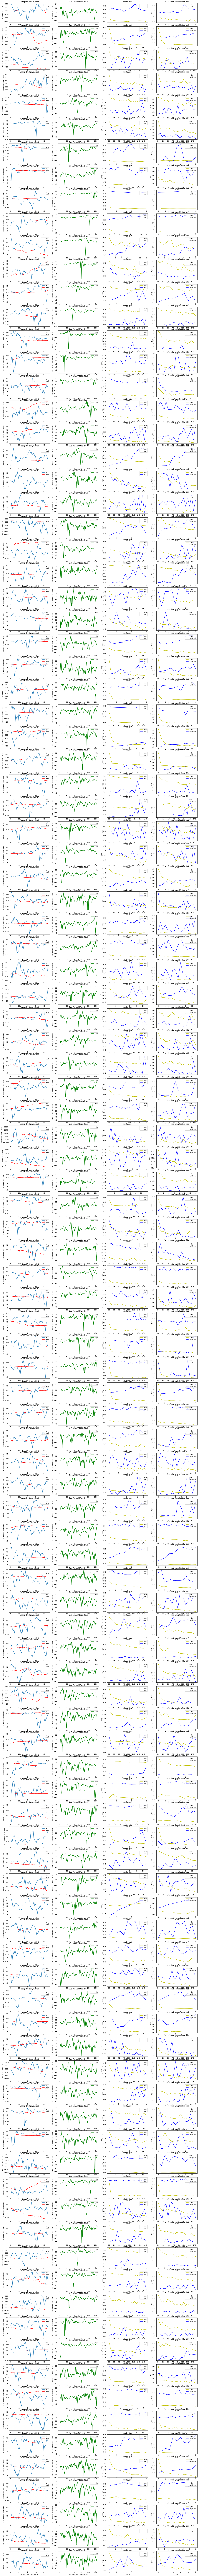

In [18]:
l1_rnn = 0.01653480436240602
l2_rnn = 0.0792386474
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, RnnDlModel_test(L1 = l1_rnn, L2 = l2_rnn, epochs = 20, patience = 10))



###### Exporting and viewing results

In [43]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

name                                         fold_score  mean_score  \
20  LinearReg  [0.06422, 0.08158, 0.10233, 0.10397, 0.0928, 0...     0.08007   
46        RNN  [0.08021, 0.07414, 0.15304, 0.09484, 0.09262, ...     0.08496   
45        RNN  [0.25442, 0.06626, 0.10818, 0.12145, 0.09141, ...     0.09662   
21      Dummy  [0.06752, 0.08603, 0.11788, 0.13216, 0.14218, ...     0.11057   
42        RNN  [0.14024, 0.06254, 0.10764, 0.08193, 0.24885, ...     0.13397   
10  LinearReg  [0.13612, 0.21353, 0.30214, 0.10699, 0.19859, ...     0.16727   
38  LinearReg  [0.13771, 0.21647, 0.30717, 0.10733, 0.20077, ...     0.16939   
25  LinearReg  [0.13809, 0.21718, 0.30844, 0.1074, 0.20131, 0...     0.16991   
17  LinearReg  [0.14206, 0.22432, 0.32162, 0.10804, 0.20692, ...     0.17525   
11  LinearReg  [0.14258, 0.22526, 0.32338, 0.10813, 0.20769, ...     0.17597   
14  LinearReg  [0.14356, 0.22703, 0.32675, 0.10832, 0.20915, ...     0.17733   
7   LinearReg  [0.14811, 0.23535, 0.34311, 0.10916, 0.21625, ...     0.18392   
22  LinearReg  [0.1485, 0.23608, 0.34458, 0.10923, 0.21689, 0...     0.18452   
18  LinearReg  [0.15123, 0.24124, 0.35522, 0.10981, 0.2216, 0...     0.18882   
6   LinearReg  [0.15154, 0.24184, 0.3565, 0.10987, 0.22217, 0...     0.18933   
4   LinearReg  [0.15219, 0.24308, 0.35915, 0.10999, 0.22336, ...     0.19040   
5   LinearReg  [0.15304, 0.24473, 0.36273, 0.11016, 0.225, 0....     0.19182   
35  LinearReg  [0.15322, 0.24509, 0.3635, 0.1102, 0.22536, 0....     0.19213   
16  LinearReg  [0.15433, 0.24688, 0.36744, 0.1104, 0.22718, 0...     0.19370   
36  LinearReg  [0.15546, 0.2487, 0.37153, 0.11062, 0.22909, 0...     0.19534   
15  LinearReg  [0.15629, 0.25013, 0.37476, 0.11079, 0.23062, ...     0.19664   
37  LinearReg  [0.15643, 0.25039, 0.37538, 0.11083, 0.23091, ...     0.19689   
33  LinearReg  [0.15746, 0.25253, 0.38032, 0.11109, 0.23331, ...     0.19889   
2   LinearReg  [0.15875, 0.25477, 0.38564, 0.11137, 0.23592, ...     0.20103   
12  LinearReg  [0.1602, 0.25723, 0.39163, 0.11171, 0.23892, 0...     0.20345   
31  LinearReg  [0.16138, 0.26, 0.39859, 0.11209, 0.24247, 0.3...     0.20624   
32  LinearReg  [0.1615, 0.26027, 0.39929, 0.11213, 0.24283, 0...     0.20652   
3   LinearReg  [0.16197, 0.26144, 0.40232, 0.11229, 0.24441, ...     0.20774   
0   LinearReg  [0.16269, 0.2633, 0.40722, 0.11255, 0.24699, 0...     0.20971   
23  LinearReg  [0.1644, 0.26967, 0.4212, 0.11325, 0.25466, 0....     0.21532   
26  LinearReg  [0.16589, 0.27603, 0.44034, 0.11413, 0.26599, ...     0.22293   
8   LinearReg  [0.1662, 0.28163, 0.45969, 0.11494, 0.27859, 0...     0.23059   
29  LinearReg  [0.16614, 0.28238, 0.46256, 0.11504, 0.28055, ...     0.23173   
13  LinearReg  [0.16549, 0.28577, 0.47637, 0.11552, 0.29048, ...     0.23723   
27  LinearReg  [0.16541, 0.28666, 0.48029, 0.11566, 0.29345, ...     0.23878   
30  LinearReg  [0.16178, 0.29209, 0.50732, 0.11644, 0.31503, ...     0.24929   
44        RNN  [0.0689, 0.07123, 0.11638, 0.20017, 0.19916, 0...     0.25531   
28  LinearReg  [0.15803, 0.29463, 0.52338, 0.11676, 0.33012, ...     0.25567   
1   LinearReg  [0.1574, 0.295, 0.5258, 0.11679, 0.33256, 0.41...     0.25665   
24  LinearReg  [0.14706, 0.29882, 0.55603, 0.11743, 0.3653, 0...     0.26908   
41  LinearReg  [0.13635, 0.30063, 0.58061, 0.1174, 0.39709, 0...     0.27974   
39  LinearReg  [0.13527, 0.30075, 0.58291, 0.11737, 0.40026, ...     0.28071   
34  LinearReg  [0.12487, 0.30148, 0.60465, 0.11738, 0.43215, ...     0.29027   
40  LinearReg  [0.12322, 0.30157, 0.60788, 0.11747, 0.43719, ...     0.29172   
9   LinearReg  [0.09834, 0.29143, 0.70277, 0.11837, 0.62478, ...     0.36053   
19  LinearReg  [0.1916, 0.28887, 0.79484, 0.24018, 0.55197, 0...     0.64564   
43        RNN  [0.13022, 0.13787, 0.33697, 0.17142, 0.09978, ...    16.67472   

    min_score  max_score                                        hyperparams  \
20    0.03786    0.11896                  {'alpha': 15, 'l1_ratio': 0.0001}   
46    0.04